<a href="https://colab.research.google.com/github/vimalkumarasamy/ML_sample_implementations/blob/master/U_net_with_camvid_data_load_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# installing the examples from TF
pip install -q git+https://github.com/tensorflow/examples.git

In [0]:
# importing the libraries and packages
import tensorflow as tf
import numpy as np
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
# downloading the dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteC4YYQO/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0.incompleteC4YYQO/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.1.0. Subsequent calls will reuse this data.


In [0]:
# normalize function makes the image pixel intensities range between 0 and 1 
# makes the classes of mask range from 0 to n
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [0]:
# this function resizes the images to 128 X 128 
# for 50% of the images it flips the images for better generalization of the model
# the input object datapoint is expected to have the image and segmentation_mask
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [0]:
# loading the image for test dataset, which won't be part of the tf graph
# there is no flipping required for the test dataset, as we need to evaluate them as it is
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [7]:
# some statistics about the dataset
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

print("Train length:", TRAIN_LENGTH)

Train length: 3680


In [0]:
# loading the dataset from the object
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])


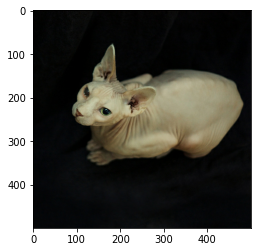

[1 2 3]


In [9]:
# exploring the elements contained in the dataset
for i in dataset['train'].take(1):
  print(i.keys())
  filename=i['file_name']
  image=i['image']
  seg=i['segmentation_mask']
  img=image.numpy()
  plt.imshow(img)
  plt.show()
  seg=seg.numpy()
  print(np.unique(seg))

In [0]:
# shuffling the training dataset randomly and prefetching the training dataset for faster train
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [0]:
# this function displays the images 
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [12]:
# Model specific details

OUTPUT_CHANNELS = 3
# pretrained MobileNetV2 model from keras applications
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)


9412608/9406464 [==============================] - 0s 0us/step


In [0]:
# building these layers on top the pretrained model

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

In [0]:
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [0]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [0]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

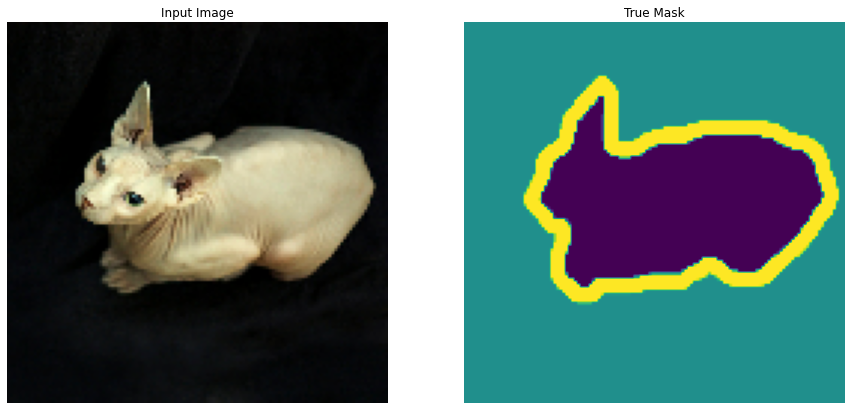

In [23]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
  display([sample_image, sample_mask])

In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

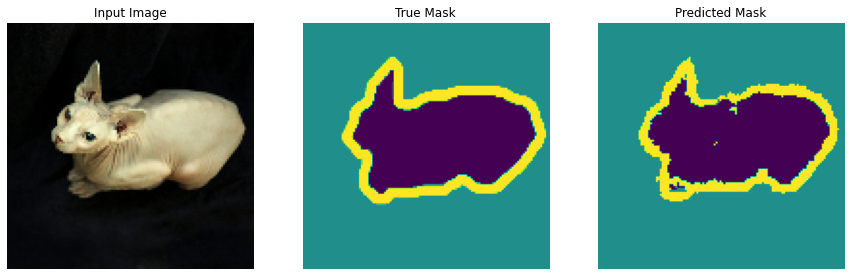


Sample Prediction after epoch 1

57/57 [==============================] - 317s 6s/step - loss: 0.2563 - accuracy: 0.8922 - val_loss: 0.2813 - val_accuracy: 0.8857


In [31]:
EPOCHS = 1
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [33]:
# reading an image from camvid dataset
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def plot(img):
  plt.imshow(img)
  plt.show()

In [0]:
img_path = 'gdrive/My Drive/Spring 2020/Machine Learning/Project/Semantic-Segmentation-Suite/CamVid/train/0006R0_f02460.png'
label_path = 'gdrive/My Drive/Spring 2020/Machine Learning/Project/Semantic-Segmentation-Suite/CamVid/train_labels/0006R0_f02460_L.png'
#gdrive/My Drive/Spring 2020/Machine Learning/Project/Semantic-Segmentation-Suite/CamVid/train/0006R0_f03570.png
import matplotlib.image as mpimg 
import cv2
# img=mpimg.imread(img_path)
# label=mpimg.imread(label_path)

img=cv2.imread(img_path,1)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
label=cv2.imread(label_path,1)
label = cv2.cvtColor(label,cv2.COLOR_BGR2RGB)

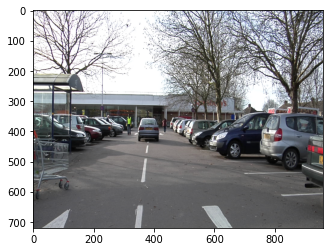

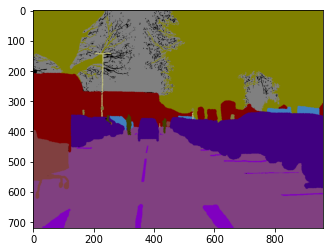

In [108]:
plot(img)
plot(label)

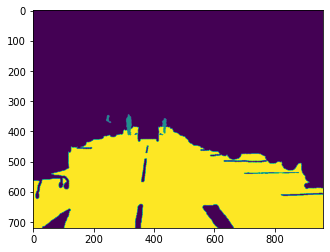

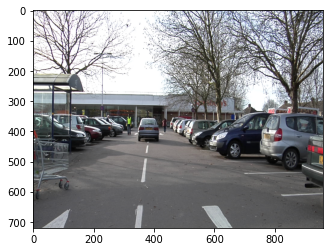

In [62]:
label_mask=np.zeros((label.shape[0],label.shape[1]))
for i in range(label.shape[0]):
  for j in range(label.shape[1]):
    if label[i][j][0]==64 and label[i][j][1]==64 and label[i][j][2]==0:
      label_mask[i,j] = 1 
    elif label[i][j][0]==128 and label[i][j][1]==64 and label[i][j][2]==128:
      label_mask[i,j] = 2
plot(label_mask)
plot(img)

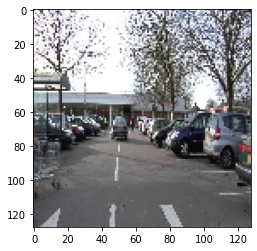

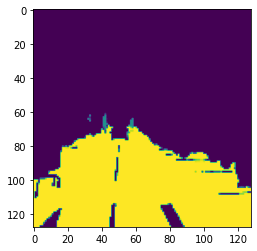

In [72]:
img_input       =cv2.resize(img,(128,128))
label_mask_input=cv2.resize(label_mask,(128,128))

plot(img_input)
plot(label_mask_input)

img_input = np.expand_dims(img_input, axis=0)
label_mask_input = np.expand_dims(label_mask_input, axis=0)

In [0]:
#model_history = model.fit(x=img_input,y=label_mask_input,epochs=100)

In [0]:
pred=model.predict(img_input)
pred_0=pred[0]

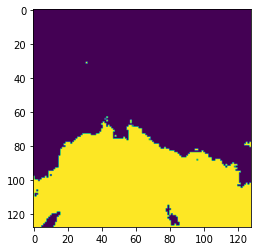

In [90]:
pred_max=np.zeros((pred_0.shape[0],pred_0.shape[1]))
for i in range(pred_0.shape[0]):
  for j in range(pred_0.shape[1]):
    if pred_0[i,j,0]>pred_0[i,j,1] and pred_0[i,j,0]>pred_0[i,j,2]:
      pred_max[i,j]=0
    elif pred_0[i,j,1]>pred_0[i,j,0] and pred_0[i,j,1]>pred_0[i,j,2]:
      pred_max[i,j]=1
    else:
      pred_max[i,j]=2

plot(pred_max)


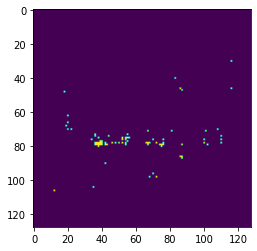

In [0]:
# Let's make our model super strong
import os
img_path = 'gdrive/My Drive/Spring 2020/Machine Learning/Project/Semantic-Segmentation-Suite/CamVid'

def prepare_model_input(img_path,n,channels):
  train_input,train_label = np.zeros((1,n,n,3)),np.zeros((1,n,n,1))
  idx = 1
  for file in os.listdir(img_path + "/train" ):
    img=cv2.imread(img_path + "/train/" + file,1)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(n,n))
    img = np.expand_dims(img, axis=0)
    if(idx=1):
      train_input = img
    else:
      train_input= np.concatenate((train_input,img))
      idx+=1
    label=cv2.imread(img_path + "/train_labels/" + file + "_L",1)
    label = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if(channels==3):
      label = define_channels(label)
    label=cv2.resize(label,(n,n))
    train_label = np.concatenate((train_label,label))
  return train_input,train_label

train_input, train_label = prepare_model_input(img_path,128,3)
print(train_input.shape)


In [125]:
len(train_input)

421

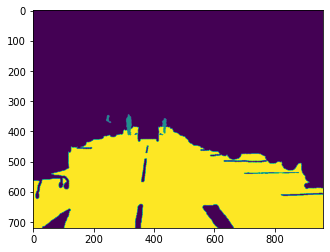

In [121]:
label = 'gdrive/My Drive/Spring 2020/Machine Learning/Project/Semantic-Segmentation-Suite/CamVid//train_labels/0006R0_f02460_L.png'
label=cv2.imread(label_path,1)
label = cv2.cvtColor(label,cv2.COLOR_BGR2RGB)
lab = define_channels(label)
plot(lab)

In [0]:
def define_channels(label):
  label_mask=np.zeros((label.shape[0],label.shape[1]))
  for i in range(label.shape[0]):
    for j in range(label.shape[1]):
      if label[i][j][0]==64 and label[i][j][1]==64 and label[i][j][2]==0:
        label_mask[i,j] = 1 
      elif label[i][j][0]==128 and label[i][j][1]==64 and label[i][j][2]==128:
        label_mask[i,j] = 2
  return label_mask

In [0]:
x=np.zeros((1,128,128,3))
y=np.ones((1,128,128,3))
z=np.concatenate((x,y))

In [143]:
z.shape

(2, 128, 128, 3)

1.0